In [1]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00


In [2]:
!pip install pygmo


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 64.7 MB/s eta 0:00:00


**Code from Chapter 6**

Best Individual: [126.46484532 416.0958147  308.15693088 ...  67.29244369 398.56654902
 278.03103218]
Best Fitness (Total Profit): 8870218.0
   Product Price  Optimized Price
0         327.75       126.464845
1         327.75       416.095815
2         327.75       308.156931
3         327.75       278.910980
4         327.75        89.151790


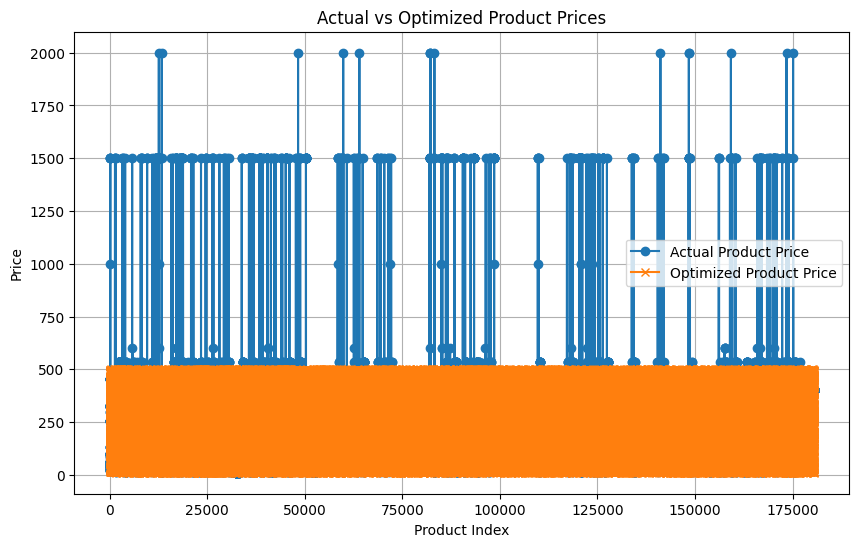

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import pygmo as pg

# Load dataset
df = pd.read_csv('/content/sample_data/DataCoSupplyChainDatasetCleaned.csv')

# Create 'Order_Demand' feature
# Assuming 'Order_Demand' can be derived from 'Order Item Quantity'
df['Order_Demand'] = df['Order Item Quantity']

# Create 'Product Category' feature
# Assuming 'Product Category' can be derived from 'Category Name'
df['Product Category'] = df['Category Name']

# Extract relevant features
df = df[['Product Price', 'Order_Demand', 'Sales per customer', 'Order Profit Per Order', 'Customer Segment', 'Product Category']]

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the objective function data using PyTorch
def calc_profit(product_prices, order_quantity, benefit_per_order):
    product_prices = torch.tensor(product_prices, dtype=torch.float32, device=device)
    order_quantity = torch.tensor(order_quantity, dtype=torch.float32, device=device)
    benefit_per_order = torch.tensor(benefit_per_order, dtype=torch.float32, device=device)

    total_profit = torch.sum(benefit_per_order * order_quantity).item()
    return -total_profit  # Negative for minimization

# Objective function for ABC
def fitness_function(solution):
    product_prices = solution
    order_quantity = df['Order_Demand'].values
    benefit_per_order = df['Order Profit Per Order'].values

    total_profit = calc_profit(product_prices, order_quantity, benefit_per_order)
    return total_profit

# PyGMO problem definition
class ProductPricingProblem:
    def __init__(self):
        self.dim = len(df['Product Price'])
        self.bounds = ([10] * self.dim, [500] * self.dim)

    def fitness(self, x):
        return [fitness_function(x)]

    def get_bounds(self):
        return self.bounds

# Create the problem instance
problem = pg.problem(ProductPricingProblem())

# Create the ABC algorithm instance
algo = pg.algorithm(pg.bee_colony(gen=100))

# Create the population
population = pg.population(problem, size=50)

# Evolve the population
population = algo.evolve(population)

# Extract the best solution
best_solution = population.champion_x
best_fitness = population.champion_f[0]

# Print the best solution and its fitness
print(f"Best Individual: {best_solution}")
print(f"Best Fitness (Total Profit): {-best_fitness}")

# Compare actual product prices vs optimized product prices
df['Optimized Price'] = best_solution
comparison_df = df[['Product Price', 'Optimized Price']]
print(comparison_df.head())

# Plotting the actual vs optimized product prices
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Product Price'].values, label='Actual Product Price', marker='o')
plt.plot(comparison_df['Optimized Price'].values, label='Optimized Product Price', marker='x')
plt.xlabel('Product Index')
plt.ylabel('Price')
plt.title('Actual vs Optimized Product Prices')
plt.legend()
plt.grid(True)
plt.show()

Best Individual: [333.300794   176.48381919 490.95837556 ... 148.28544396 256.74685258
 138.2586137 ]
Best Fitness (Total Profit): 8870218.0
   Product Price  Optimized Price
0         327.75       333.300794
1         327.75       176.483819
2         327.75       490.958376
3         327.75       352.402105
4         327.75       302.502256


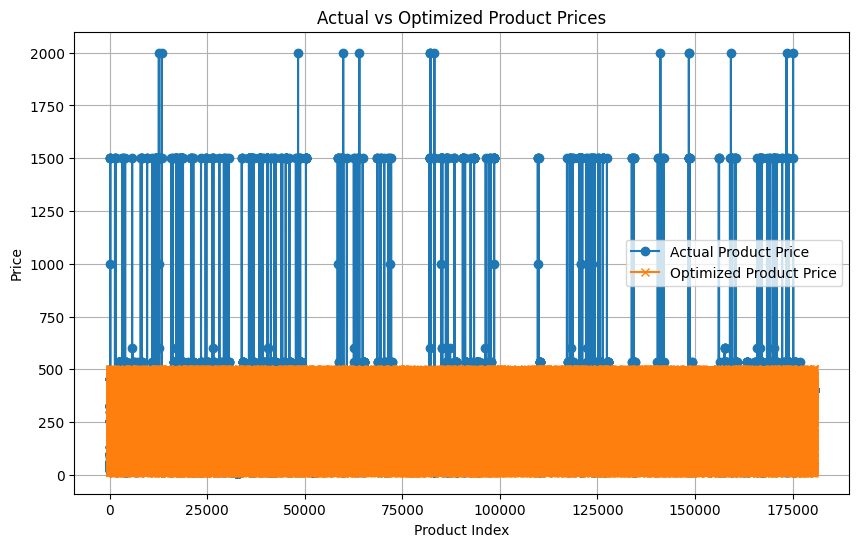

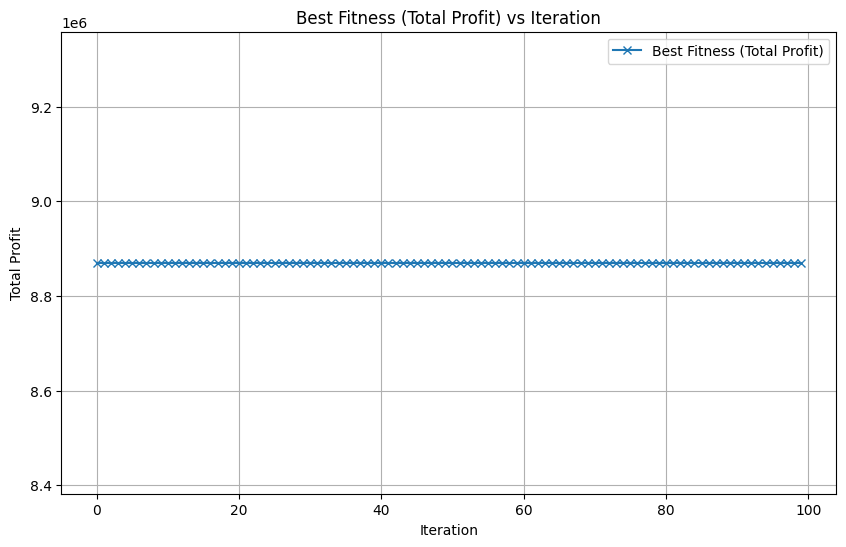

In [6]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import pygmo as pg

# Load dataset
df = pd.read_csv('/content/sample_data/DataCoSupplyChainDatasetCleaned.csv')

# Extract relevant features
df['Order_Demand'] = df['Order Item Quantity']
df['Product Category'] = df['Category Name']
df = df[['Product Price', 'Order_Demand', 'Order Profit Per Order']]

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the objective function using PyTorch
def calc_profit(product_prices, order_quantity, benefit_per_order):
    product_prices = torch.tensor(product_prices, dtype=torch.float32, device=device)
    order_quantity = torch.tensor(order_quantity, dtype=torch.float32, device=device)
    benefit_per_order = torch.tensor(benefit_per_order, dtype=torch.float32, device=device)

    total_profit = torch.sum(benefit_per_order * order_quantity).item()
    return -total_profit  # Negative for minimization

# Objective function for optimization
def fitness_function(solution):
    order_quantity = df['Order_Demand'].values
    benefit_per_order = df['Order Profit Per Order'].values

    return calc_profit(solution, order_quantity, benefit_per_order)

# PyGMO problem definition
class ProductPricingProblem:
    def __init__(self):
        self.dim = len(df['Product Price'])
        self.bounds = ([10] * self.dim, [500] * self.dim)

    def fitness(self, x):
        return [fitness_function(x)]

    def get_bounds(self):
        return self.bounds

# Create the problem instance
problem = pg.problem(ProductPricingProblem())

# Create the ABC algorithm instance
algo = pg.algorithm(pg.bee_colony(gen=1))  # Set generations to 1 for iterative tracking

# Create the population
population = pg.population(problem, size=50)

# Track best fitness over iterations
fitness_over_iterations = []
for i in range(100):
    population = algo.evolve(population)
    best_fitness = population.champion_f[0]
    fitness_over_iterations.append(-best_fitness)

    # Reinitialize the algorithm to maintain diversity in search
    algo = pg.algorithm(pg.bee_colony(gen=1))

# Extract the best solution
best_solution = population.champion_x
best_fitness = population.champion_f[0]

# Print the best solution and its fitness
print(f"Best Individual: {best_solution}")
print(f"Best Fitness (Total Profit): {-best_fitness}")

# Compare actual product prices vs optimized product prices
df['Optimized Price'] = best_solution
comparison_df = df[['Product Price', 'Optimized Price']]
print(comparison_df.head())

# Plotting the actual vs optimized product prices
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Product Price'].values, label='Actual Product Price', marker='o')
plt.plot(comparison_df['Optimized Price'].values, label='Optimized Product Price', marker='x')
plt.xlabel('Product Index')
plt.ylabel('Price')
plt.title('Actual vs Optimized Product Prices')
plt.legend()
plt.grid(True)
plt.show()

# Plotting best fitness (Total Profit) vs iteration
plt.figure(figsize=(10, 6))
plt.plot(fitness_over_iterations, label='Best Fitness (Total Profit)', marker='x')
plt.xlabel('Iteration')
plt.ylabel('Total Profit')
plt.title('Best Fitness (Total Profit) vs Iteration')
plt.legend()
plt.grid(True)
plt.show()

**Improved code with Demand function**

Best Individual: [235.18823832  60.38575042 214.87653561 ...  31.370605   436.32190847
  20.18339503]
Best Fitness (Total Profit): 18705584.0
   Product Price  Optimized Price
0         327.75       235.188238
1         327.75        60.385750
2         327.75       214.876536
3         327.75       443.918266
4         327.75       370.064622


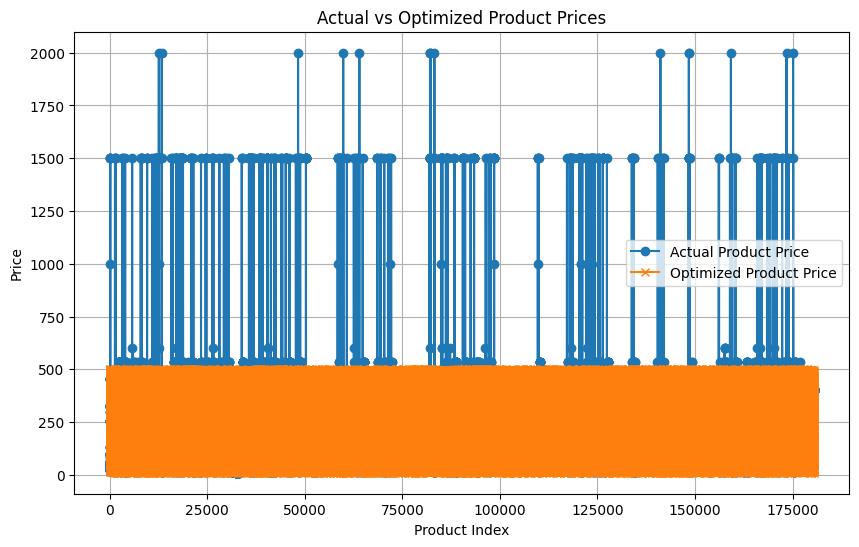

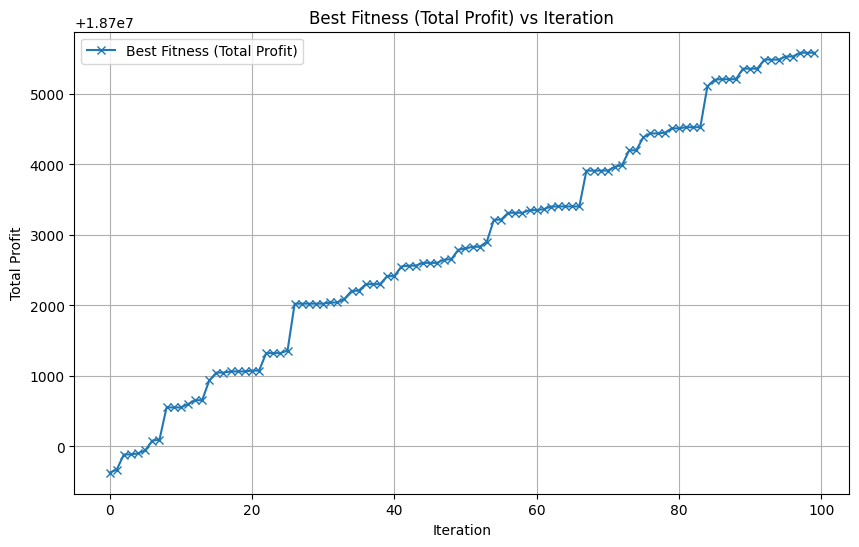

In [9]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import pygmo as pg
from sklearn.linear_model import LinearRegression

# Load dataset
df = pd.read_csv('/content/sample_data/DataCoSupplyChainDatasetCleaned.csv')

# Extract relevant features
df['Order_Demand'] = df['Order Item Quantity']
df['Product Category'] = df['Category Name']
df = df[['Product Price', 'Order_Demand', 'Order Profit Per Order']]

# Calculate Product Cost
df['Product Cost'] = df['Product Price'] - (df['Order Profit Per Order'] / df['Order_Demand'])

# Fit a demand function (linear regression) to model how demand changes with price
X = df['Product Price'].values.reshape(-1, 1)
y = df['Order_Demand'].values

model = LinearRegression()
model.fit(X, y)

# Coefficients for the demand function: Order_Demand = a + b * Product Price
a = model.intercept_
b = model.coef_[0]

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the objective function using PyTorch
def calc_profit(product_prices, product_costs, a, b):
    product_prices = torch.tensor(product_prices, dtype=torch.float32, device=device)
    product_costs = torch.tensor(product_costs, dtype=torch.float32, device=device)

    # Calculate Order_Demand using the demand function
    order_demand = a + b * product_prices
    order_demand = torch.clamp(order_demand, min=0)  # Ensure demand is non-negative

    # Total profit is (price - cost) * demand
    profit_per_product = (product_prices - product_costs) * order_demand
    total_profit = torch.sum(profit_per_product).item()

    return -total_profit  # Negative for minimization

# Objective function for optimization
def fitness_function(solution):
    product_costs = df['Product Cost'].values
    return [calc_profit(solution, product_costs, a, b)]

# PyGMO problem definition
class ProductPricingProblem:
    def __init__(self):
        self.dim = len(df['Product Price'])
        self.bounds = ([10] * self.dim, [500] * self.dim)

    def fitness(self, x):
        return fitness_function(x)

    def get_bounds(self):
        return self.bounds

# Create the problem instance
problem = pg.problem(ProductPricingProblem())

# Create the ABC algorithm instance
algo = pg.algorithm(pg.bee_colony(gen=1))  # Set generations to 1 for iterative tracking

# Create the population
population = pg.population(problem, size=50)

# Track best fitness over iterations
fitness_over_iterations = []
for i in range(100):
    population = algo.evolve(population)
    best_fitness = population.champion_f[0]
    fitness_over_iterations.append(-best_fitness)

    # Reinitialize the algorithm to maintain diversity in search
    algo = pg.algorithm(pg.bee_colony(gen=1))

# Extract the best solution
best_solution = population.champion_x
best_fitness = population.champion_f[0]

# Print the best solution and its fitness
print(f"Best Individual: {best_solution}")
print(f"Best Fitness (Total Profit): {-best_fitness}")

# Compare actual product prices vs optimized product prices
df['Optimized Price'] = best_solution
comparison_df = df[['Product Price', 'Optimized Price']]
print(comparison_df.head())

# Plotting the actual vs optimized product prices
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Product Price'].values, label='Actual Product Price', marker='o')
plt.plot(comparison_df['Optimized Price'].values, label='Optimized Product Price', marker='x')
plt.xlabel('Product Index')
plt.ylabel('Price')
plt.title('Actual vs Optimized Product Prices')
plt.legend()
plt.grid(True)
plt.show()

# Plotting best fitness (Total Profit) vs iteration
plt.figure(figsize=(10, 6))
plt.plot(fitness_over_iterations, label='Best Fitness (Total Profit)', marker='x')
plt.xlabel('Iteration')
plt.ylabel('Total Profit')
plt.title('Best Fitness (Total Profit) vs Iteration')
plt.legend()
plt.grid(True)
plt.show()
